In [37]:
def simple_noise_reduction(audio, rate):
    # Sử dụng bộ lọc thông thấp đơn giản
    from scipy.signal import butter, filtfilt
    
    # Thiết kế bộ lọc thông thấp
    nyquist = rate / 2
    cutoff = 3000  # Hz
    normal_cutoff = cutoff / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    
    # Áp dụng bộ lọc
    filtered_audio = filtfilt(b, a, audio)
    
    return filtered_audio

In [38]:
import os
import numpy as np
from scipy.io import wavfile
import librosa

def process_audio_file(input_path, output_path):
    # Đọc file và chuyển về mono, 16kHz
    audio, rate = librosa.load(input_path, sr=16000, mono=True)
    
    # Giảm nhiễu đơn giản
    audio = simple_noise_reduction(audio, rate)
    
    # Tìm đoạn 1s có năng lượng cao nhất
    window_sec = 1.0
    window_len = int(window_sec * rate)
    stride = int(0.1 * rate)
    
    max_energy = 0
    best_segment = None
    
    # Tìm đoạn có năng lượng cao nhất
    for i in range(0, len(audio) - window_len, stride):
        window = audio[i:i+window_len]
        energy = np.sum(window**2)
        if energy > max_energy:
            max_energy = energy
            best_segment = window
    
    # Chuẩn hóa âm lượng
    if best_segment is not None:
        max_val = np.max(np.abs(best_segment))
        if max_val > 0:
            best_segment = best_segment / max_val * 0.99
    
    # Chuyển về int16 để ghi WAV
    final_output = (best_segment * 32767).astype(np.int16)
    
    # Ghi file WAV
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    wavfile.write(output_path, rate, final_output)
    
    return final_output, rate

In [39]:
from tqdm import tqdm

# Tạo thư mục processed_mcu nếu chưa tồn tại
os.makedirs("../data/processed_mcu", exist_ok=True)

# Xử lý tất cả các file trong thư mục raw
raw_dir = "../data/raw"
for command_dir in tqdm(os.listdir(raw_dir), desc="Processing commands"):
    command_path = os.path.join(raw_dir, command_dir)
    if not os.path.isdir(command_path):
        continue

    # Tạo thư mục tương ứng trong processed_mcu
    processed_command_dir = os.path.join("../data/processed_mcu", command_dir)
    os.makedirs(processed_command_dir, exist_ok=True)

    # Xử lý tất cả các file WAV trong thư mục lệnh này
    for wav_file in tqdm(os.listdir(command_path), desc=f"Processing {command_dir}", leave=False):
        if not wav_file.endswith('.wav'):
            continue

        input_path = os.path.join(command_path, wav_file)
        output_path = os.path.join(processed_command_dir, wav_file)
        
        try:
            process_audio_file(input_path, output_path)
        except Exception as e:
            print(f"Error processing {input_path}: {str(e)}")

Processing commands: 100%|██████████| 12/12 [00:00<00:00, 14.05it/s]


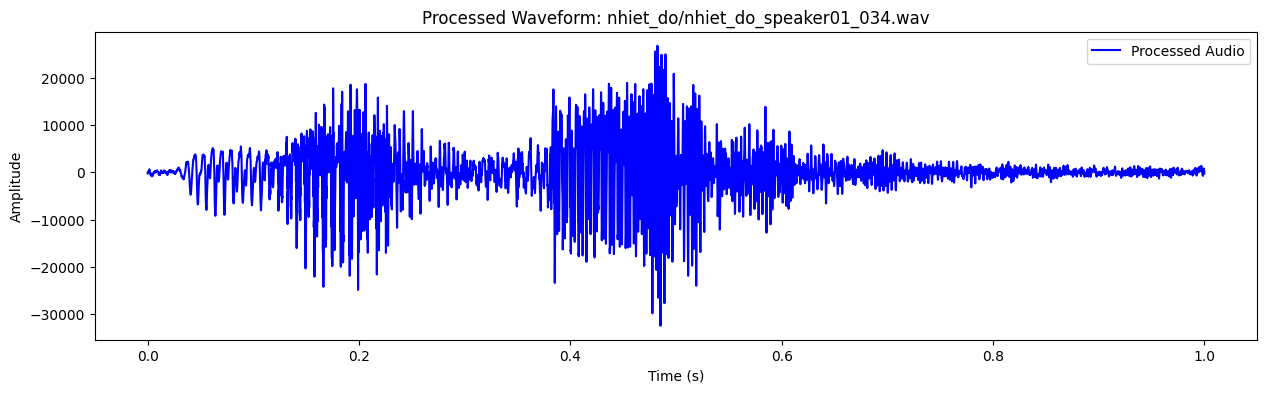

In [40]:
import random
import matplotlib.pyplot as plt
from IPython.display import Audio

# Chọn ngẫu nhiên một file đã xử lý
processed_dir = "../data/processed_mcu"  # Thay đổi đường dẫn
command_dirs = [d for d in os.listdir(processed_dir) if os.path.isdir(os.path.join(processed_dir, d))]
command_dir = random.choice(command_dirs)
command_path = os.path.join(processed_dir, command_dir)

wav_files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
wav_file = random.choice(wav_files)
processed_path = os.path.join(command_path, wav_file)

# Đọc và hiển thị waveform
rate, processed_samples = wavfile.read(processed_path)

# Vẽ waveform
time = np.linspace(0, len(processed_samples)/rate, num=len(processed_samples))
plt.figure(figsize=(15, 4))
plt.plot(time, processed_samples, label="Processed Audio", color='blue')
plt.title(f"Processed Waveform: {command_dir}/{wav_file}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# Phát audio
Audio(processed_samples, rate=rate)